<div style="float:right",size="5"><b>Carolina Santos | Data Science Candidate | 2020<b><div>

<font size="6"> __Forecasting Vancouver Crime:__<font>

# Introduction

The City of Vancouver (Canada) has 675,218 people (2017) and the Greater Vancouver Area is the third-largest metropolitan area in Canada and is one of the Top 10 worldwide cities for quality of life. I will explore if it's possible to ___accurately predict the number of daily crimes in the city of Vancouver___ by using the Python package called [__Prophet__] (https://facebook.github.io/prophet/), developed by Facebook in 2017 by the Core Data Science team.

## Data Source and Attributes

### Vancouver Police Department (VPD) [Geodash Open Data](https://geodash.vpd.ca/opendata/)

   * __Attributes Description__: 
        * __Description__: GeoDASH stands for Geographic Data Analysis and Statistics Hub. It is a crime mapping tool used by Vancouver Police Department (VPD) to inform residents on the crime activities happening in Vancouver. This data set carries the crimes that occurred in the city and is based upon information contained in the VPD Records Management System. The crime classification and file status may change at any time based on the dynamic nature of police investigations. The VPD has protected the privacy of all parties involved in the incidents reported. No personal or identifying information has been provided in the data. Locations for reported incidents involving Offences Against a Person have been deliberately randomized to several blocks and offset to an intersection. No time or street location name will be provided for these offences. For property related offences, the VPD has provided the location to the hundred block of these incidents within the general area of the block. All data must be considered offset and users should not interpret any locations as related to a specific person or specific property. 

        * __Type__:
            - __Break and Enter Commercial__: (Commercial Break and Enter) Breaking and entering into a commercial property with intent to commit an offence
            - __Break and Enter Residential/Other__: (Residential Break and Enter) Breaking and entering into a dwelling/house/apartment/garage with intent to commit an offence 
            - __Vehicle Collision or Pedestrian Struck (with Fatality)__: Includes primarily pedestrian or cyclist struck and killed by a vehicle. It also includes vehicle to vehicle fatal accidents, however these incidents are fewer in number when compared to the overall data set. Note: There is no neighbourhood information. 
            - __Vehicle Collision or Pedestrian Struck (with Injury)__: Includes all categories of vehicle involved accidents with injuries. This includes pedestrian and cyclist involved incidents with injuries. Note: There is no neighbourhood information
            - __Homicide__: A person, directly or indirectly, by any means, causes the death of another person.
            - Mischief: A person commits mischief that willfully causes malicious destruction, damage, or defacement of property. This also includes any public mischief towards another person.
            - __Mischief__: A person commits mischief that willfully causes malicious destruction, damage, or defacement of property. 

            - __Offence Against a Person__: An attack on a person causing harm that may include usage of a weapon.
            - __Other Theft__: Theft of property that includes personal items (purse, wallet, cellphone, laptop, etc.), bicycle, etc.
            - __Theft from Vehicle__: Theft of property from a vehicle
            - __Theft of Vehicle__: Theft of a vehicle, motorcycle, or any motor vehicle 
            - __Theft of Bicycle__: Theft of a bicycle. Note: There is no neighbourhood information
        * __YEAR__: A four-digit field that indicates the year when the reported crime activity occurred
        * __MONTH__: A numeric field that indicates the month when the reported crime activity occurred
        * __DAY__: A two-digit field that indicates the day of the month when the reported crime activity occurred
        * __HOUR__: A two-digit field that indicates the hour time (in 24 hours format) when the reported crime activity occurred Note: This information is based on the findings of the police investigation. No time information will be provided for Offences Against a Person crime type 
        * __MINUTE__: A two-digit field that indicates the minute when the reported crime activity occurred Note: This information is based on the findings of the police investigation. No time information will be provided for Offences Against a Person crime type
        * __HUNDRED_BLOCK__: Generalized location of the report crime activity
        * __NEIGHBOURHOOD__: The Vancouver Police Department uses the _Statistics Canada_ definition of neighbourhoods within municipalities. Neighbourhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA).
        * __X__: Coordinate values are projected in UTM Zone 10. All data must be considered offset and users should not interpret any locations as related to a specific person or specific property.
        * __Y__: Coordinate values are projected in UTM Zone 10. All data must be considered offset and users should not interpret any locations as related to a specific person or specific property.
        
        

### Local Boundary Data (WGS84 EPSG:4326): [Open Data Portal](https://opendata.vancouver.ca/explore/dataset/local-area-boundary/information/)

* __Attributes Description__: 
     * __Description__: This data set contains the boundaries for the City's 22 local areas (also known as local planning areas). Local area boundaries generally follow street centrelines in a GeoJSON format.GeoJSON is a geospatial data interchange format based on JavaScript Object Notation (JSON). GeoJSON uses a geographic coordinate reference system, World Geodetic System 1984, and units of decimal degrees (IETF).
    * __Attributes Description__:
        * __Type__:
            - __MAPID__: Label that identifies the neighbourhood (i.e. AR = Arbutus-Ridge).
            - __Name__: Full name of the neighbourhood.
            - __Geom__: Spatial representation of Local Area, representing points, curves, and surfaces in coordinate space.
            - __geo_point_2d__: For type "Point", the "coordinates" member is a single position.

## Exploratory Data Analysis (EDA)

Prophet and Geopandas need to be first installed to the Conda environment so they can run on the notebook:
* `conda install geopandas` - open source project to make working with geospatial data in python easier.
* `pip install fbprophet` - open source library for univariate time series forecasting developed by Facebook.

In [35]:
# importing the libraries to be used on the analysis

# data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# plotting
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# geographic
import geopandas as gpd

# forecasting
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_forecast_component
import holidays

### Overview

#### Choosing the Data to be analyzed

We have two options of data for analysis:

* __Dynamic:__ Importing data straight from the VPD website, updated every Sunday.

In [36]:
# importing the updated file directly from the VPD 
#df = pd.read_csv("http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.csv")      

* __Static__: Using data from 2020-10-16 csv file.

In [37]:
df = pd.read_csv("Data/crimedata_csv_all_years.csv")

#### Verifying the Dataframe Structure

The file has the following structure (first 5 rows):

In [38]:
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5453433.000
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5457109.822
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.7798,5459174.338
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5459166.140
4,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9434,5459166.140


In [39]:
print(f' The dataset pulled today shows crimes from {df["YEAR"].min()} to {df["YEAR"].max()}, and it has {df.shape[0]} rows and {df.shape[1]} columns.')

 The dataset pulled today shows crimes from 2003 to 2020, and it has 655912 rows and 10 columns.


For the details of each column type:

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655912 entries, 0 to 655911
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           655912 non-null  object 
 1   YEAR           655912 non-null  int64  
 2   MONTH          655912 non-null  int64  
 3   DAY            655912 non-null  int64  
 4   HOUR           655912 non-null  int64  
 5   MINUTE         655912 non-null  int64  
 6   HUNDRED_BLOCK  655902 non-null  object 
 7   NEIGHBOURHOOD  587292 non-null  object 
 8   X              655791 non-null  float64
 9   Y              655791 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 50.0+ MB


We will now concatenate the `YEAR, MONTH, DAY, HOUR, MINUTE` columns following the format `"yyyy-mm-dd hh:mm:ss"` and convert it to `datetime64` object so we can do the time series analysis and other explorations:

In [41]:
# Combining the columns YEAR, MONTH, DAY, HOUR and MINUTE into one column and dropping the ones used as source
df['DATE_TIME'] = pd.to_datetime(df[["YEAR", "MONTH", "DAY", "HOUR", "MINUTE"]])
df = df.drop(["YEAR", "MONTH", "DAY", "HOUR", "MINUTE"], axis=1)

Here is the new structure with the consolidated DATE_TIME column:

In [42]:
# Showing the new format of the dataframe
df.head()

,TYPE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,DATE_TIME
0,Break and Enter Commercial,NaN,Oakridge,491285.0000,5453433.000,2012-12-14 08:52:00
1,Break and Enter Commercial,10XX SITKA SQ,Fairview,490612.9648,5457109.822,2019-03-07 02:06:00
2,Break and Enter Commercial,10XX ALBERNI ST,West End,491007.7798,5459174.338,2019-08-27 04:12:00
3,Break and Enter Commercial,10XX ALBERNI ST,West End,491015.9434,5459166.140,2014-08-08 05:13:00
4,Break and Enter Commercial,10XX ALBERNI ST,West End,491015.9434,5459166.140,2020-07-28 19:12:00


In [43]:
print(f' Now the dataset has {df.shape[0]} rows and {df.shape[1]} columns, and the DATE_TIME column format is {df["DATE_TIME"].dtype}.')

 Now the dataset has 655912 rows and 6 columns, and the DATE_TIME column format is datetime64[ns].


### Null Values

We will now check how many entries are null in each column and decide the best approach for those cases:

In [44]:
# Calculating the number of null entries on the dataset
df.isna().sum()

TYPE                 0
HUNDRED_BLOCK       10
NEIGHBOURHOOD    68620
X                  121
Y                  121
DATE_TIME            0
dtype: int64

> There are columns with null values and we will analyze each one separately:

##### __Column: HUNDRED_BLOCK__

There are 10 null values for the column as shown below:

In [45]:
# Blank hundred_block
df[df["HUNDRED_BLOCK"].isna()]

,TYPE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,DATE_TIME
0,Break and Enter Commercial,NaN,Oakridge,491285.0,5453433.0,2012-12-14 08:52:00
41571,Break and Enter Residential/Other,NaN,Mount Pleasant,492807.0,5457236.0,2004-05-13 09:00:00
41572,Break and Enter Residential/Other,NaN,Oakridge,491854.0,5452682.0,2006-06-21 04:00:00
41573,Break and Enter Residential/Other,NaN,Riley Park,492276.0,5454816.0,2006-03-19 05:39:00
265604,Other Theft,NaN,Central Business District,491490.0,5458911.0,2004-11-05 16:00:00
265605,Other Theft,NaN,Strathcona,493928.0,5457452.0,2005-07-18 17:52:00
265606,Other Theft,NaN,Kitsilano,489325.0,5457606.0,2003-08-08 14:30:00
333872,Theft from Vehicle,NaN,Mount Pleasant,492366.0,5456595.0,2005-08-15 06:03:00
333873,Theft from Vehicle,NaN,West Point Grey,485156.0,5457770.0,2003-07-11 07:30:00
587090,Theft of Vehicle,NaN,Victoria-Fraserview,495178.0,5452000.0,2005-02-12 22:30:00


This column carries the generalized location of the report crime activity and it would be useful in case we have entries that don't have coordinates or the `NEIGHBOURHOOD` column. We will first identify in how many entries this occurs and then decide if we should keep the column and deal with the null values or just drop it.

In [46]:
# Filter cases where the HUNDRED_BLOCK is not empty and NEIGHBOURHOOD is blank
df_hundred_block = df[df["HUNDRED_BLOCK"].notna() & df["NEIGHBOURHOOD"].isna()]
df_hundred_block.groupby(["HUNDRED_BLOCK"]).count().sort_values(by='Y', ascending=False)

,TYPE,NEIGHBOURHOOD,X,Y,DATE_TIME
HUNDRED_BLOCK,,,,,
OFFSET TO PROTECT PRIVACY,65771,0,65771,65771,65771
X NK_LOC ST,2706,0,2706,2706,2706
14XX BURRARD STREET BRDG,3,0,3,3,3
15XX GRANVILLE STREET BRDG,3,0,3,3,3
SW MARINE DR / TAMATH CRES,2,0,2,2,2
...,...,...,...,...,...
7XX SE MARINE DR / 8198 FRASER ST,1,0,0,0,1
6XX BLK - DENMAN ST,1,0,0,0,1
6XX BL0CK KINGSWAY AV,1,0,0,0,1


> Most of the null entries on the `NEIGHBOURHOOD` column, also had the `HUNDRED_BLOCK` removed for privacy reasons - labeled as `OFFSET TO PROTECT PRIVACY` AND `X NK_LOC ST` -  so we decided to drop the whole `HUNDRED_BLOCK` column from the dataset as it doesn't add meaning to the analysis.

In [47]:
# Dropping the HUNDRED_BLOCK column from the dataset
df = df.drop(["HUNDRED_BLOCK"], axis=1)

Now we will check the new structure of the table:

In [48]:
df.head()

,TYPE,NEIGHBOURHOOD,X,Y,DATE_TIME
0,Break and Enter Commercial,Oakridge,491285.0000,5453433.000,2012-12-14 08:52:00
1,Break and Enter Commercial,Fairview,490612.9648,5457109.822,2019-03-07 02:06:00
2,Break and Enter Commercial,West End,491007.7798,5459174.338,2019-08-27 04:12:00
3,Break and Enter Commercial,West End,491015.9434,5459166.140,2014-08-08 05:13:00
4,Break and Enter Commercial,West End,491015.9434,5459166.140,2020-07-28 19:12:00


___Columns: `X`, `Y` and `NEIGHBOURHOOD`___

In [49]:
# Number of null entries on the dataset
df.isna().sum()

TYPE                 0
NEIGHBOURHOOD    68620
X                  121
Y                  121
DATE_TIME            0
dtype: int64

For the remaining columns with null values, we will use the City of Vancouver GeoData file for cross reference.

In [50]:
# Creating the new dataset For EDA, we will use the CSV data on Tableau:
df.to_csv(r'Output\crimedata_w_date_time.csv', index=False,header=True)

#### Using GeoData for Null Neighbourhoods and (X,Y)

The VPD has removed the information about Neighbourhoods and/or (X,Y) coordinates for specific type of crimes.

To be able to standardize all the entries, we first need to convert our dataframe coordinates to geometries and then cross reference with the City of Vancouver local boundary file.

For the geographic conversion, we will use the package [GeoPandas](https://geopandas.org/):

_"The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS."_

In [51]:
# Converting the X and Y into standardized coordinates
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

# Transforming the dataset to the same Coordinate Reference Systems (CRS) than the City of Vancouver Boundary Data
gdf = gdf.set_crs(epsg=4326)

# VPD dataset with the X and Y as Geometry points
gdf

,TYPE,NEIGHBOURHOOD,X,Y,DATE_TIME,geometry
0,Break and Enter Commercial,Oakridge,491285.0000,5453433.000,2012-12-14 08:52:00,POINT (491285.000 5453433.000)
1,Break and Enter Commercial,Fairview,490612.9648,5457109.822,2019-03-07 02:06:00,POINT (490612.965 5457109.822)
2,Break and Enter Commercial,West End,491007.7798,5459174.338,2019-08-27 04:12:00,POINT (491007.780 5459174.338)
3,Break and Enter Commercial,West End,491015.9434,5459166.140,2014-08-08 05:13:00,POINT (491015.943 5459166.140)
4,Break and Enter Commercial,West End,491015.9434,5459166.140,2020-07-28 19:12:00,POINT (491015.943 5459166.140)
...,...,...,...,...,...,...
655907,Vehicle Collision or Pedestrian Struck (with I...,Riley Park,491786.0000,5455143.000,2003-09-01 20:45:00,POINT (491786.000 5455143.000)
655908,Vehicle Collision or Pedestrian Struck (with I...,Riley Park,491786.0000,5455143.000,2005-07-20 18:57:00,POINT (491786.000 5455143.000)
655909,Vehicle Collision or Pedestrian Struck (with I...,Riley Park,491786.0000,5455143.000,2016-06-20 18:11:00,POINT (491786.000 5455143.000)
655910,Vehicle Collision or Pedestrian Struck (with I...,Riley Park,491835.0000,5455126.000,2013-12-03 09:49:00,POINT (491835.000 5455126.000)


The new column "geometry" is the (X, Y) on the [WGS84 EPSG:4326](https://www.unoosa.org/pdf/icg/2012/template/WGS_84.pdf) format.

WGS 84 is an Earth-centered and is based on a consistent set of constants and model parameters that describe the Earth's size, shape, and gravity and geomagnetic fields. WGS 84 is the standard U.S. Department of Defense definition of a global reference system for geospatial information and is the reference system for the Global Positioning System (GPS). It is compatible with the International Terrestrial Reference System (ITRS). 


That is also the same format as the City of Vancouver Local Area Boundary file so we can standardize the neighbourhoods.

The file extracted from the City of Vancouver Open Data is a GeoJSON file with the polygons that define each neighbourhood. We will join it with the VPD data for the following benefits: 
* ability to input and identify the neighbourhood names to entries that have it NaN
* standardize the locations based on the city's geometry

In [52]:
# Importing City of Vancouver Local Area Boundary file
neighbourhoods = gpd.read_file("data/local-area-boundary.geojson")
neighbourhoods

,mapid,name,geometry
0,DS,Dunbar-Southlands,"POLYGON ((487615.515 5455027.115, 487606.108 5..."
1,KERR,Kerrisdale,"POLYGON ((486957.910 5451434.123, 487209.002 5..."
2,KIL,Killarney,"POLYGON ((498283.709 5449705.686, 497087.865 5..."
3,KITS,Kitsilano,"POLYGON ((489985.357 5458071.445, 489543.730 5..."
4,SC,South Cambie,"POLYGON ((491556.708 5453913.232, 491543.175 5..."
5,VF,Victoria-Fraserview,"POLYGON ((495860.231 5450157.767, 495741.302 5..."
6,KC,Kensington-Cedar Cottage,"POLYGON ((495882.819 5456581.278, 495878.479 5..."
7,MP,Mount Pleasant,"POLYGON ((492676.507 5457379.341, 492948.719 5..."
8,OAK,Oakridge,"POLYGON ((492310.707 5453376.091, 492269.051 5..."
9,RC,Renfrew-Collingwood,"POLYGON ((498284.908 5453557.161, 498284.265 5..."


In [53]:
# Joining both datasets based on the geometry column
sjoined = gpd.sjoin(gdf, neighbourhoods, op='within', how='inner' )

The new table has 9 columns and some of them bring the same information. We will decide the ones that will be used for future analysis:

In [54]:
# Showing table with the neighbourhoods set based on the City of Vancouver GeoJSON file
sjoined

,TYPE,NEIGHBOURHOOD,X,Y,DATE_TIME,geometry,index_right,mapid,name
0,Break and Enter Commercial,Oakridge,491285.0000,5453433.000,2012-12-14 08:52:00,POINT (491285.000 5453433.000),4,SC,South Cambie
22520,Break and Enter Commercial,South Cambie,491399.1148,5456000.366,2006-01-21 08:15:00,POINT (491399.115 5456000.366),4,SC,South Cambie
22521,Break and Enter Commercial,South Cambie,491399.1148,5456000.366,2007-01-20 14:00:00,POINT (491399.115 5456000.366),4,SC,South Cambie
22522,Break and Enter Commercial,South Cambie,491619.2177,5455914.671,2006-06-27 23:30:00,POINT (491619.218 5455914.671),4,SC,South Cambie
22523,Break and Enter Commercial,South Cambie,491620.0123,5455934.710,2018-03-04 01:55:00,POINT (491620.012 5455934.710),4,SC,South Cambie
...,...,...,...,...,...,...,...,...,...
655384,Vehicle Collision or Pedestrian Struck (with I...,Dunbar-Southlands,486096.0000,5456147.000,2019-12-12 19:24:00,POINT (486096.000 5456147.000),0,DS,Dunbar-Southlands
655385,Vehicle Collision or Pedestrian Struck (with I...,Dunbar-Southlands,486117.0000,5456146.000,2017-04-17 14:53:00,POINT (486117.000 5456146.000),0,DS,Dunbar-Southlands
655386,Vehicle Collision or Pedestrian Struck (with I...,Dunbar-Southlands,486106.0000,5454841.000,2017-05-20 21:19:00,POINT (486106.000 5454841.000),0,DS,Dunbar-Southlands
655387,Vehicle Collision or Pedestrian Struck (with I...,Dunbar-Southlands,486106.0000,5454841.000,2017-10-25 08:16:00,POINT (486106.000 5454841.000),0,DS,Dunbar-Southlands


We will now check if there are differences between the VPD and the City of Vancouver definition of neighbourhood based on the geometry:

In [55]:
# Checking the entries where the neighbourhoods are different
sjoined[sjoined["NEIGHBOURHOOD"]!=sjoined["name"]]

,TYPE,NEIGHBOURHOOD,X,Y,DATE_TIME,geometry,index_right,mapid,name
0,Break and Enter Commercial,Oakridge,491285.0000,5453433.000,2012-12-14 08:52:00,POINT (491285.000 5453433.000),4,SC,South Cambie
192407,Mischief,Riley Park,491623.4718,5455906.555,2009-05-13 19:40:00,POINT (491623.472 5455906.555),4,SC,South Cambie
192408,Mischief,Riley Park,491619.9390,5455799.247,2006-09-30 23:00:00,POINT (491619.939 5455799.247),4,SC,South Cambie
192409,Mischief,Riley Park,491619.9390,5455799.247,2008-04-25 19:00:00,POINT (491619.939 5455799.247),4,SC,South Cambie
192410,Mischief,Riley Park,491619.9390,5455799.247,2010-05-16 21:10:00,POINT (491619.939 5455799.247),4,SC,South Cambie
...,...,...,...,...,...,...,...,...,...
653324,Vehicle Collision or Pedestrian Struck (with I...,Kerrisdale,487605.0000,5453562.000,2003-05-21 18:45:00,POINT (487605.000 5453562.000),0,DS,Dunbar-Southlands
653325,Vehicle Collision or Pedestrian Struck (with I...,Kerrisdale,487605.0000,5453562.000,2013-05-28 08:49:00,POINT (487605.000 5453562.000),0,DS,Dunbar-Southlands
653326,Vehicle Collision or Pedestrian Struck (with I...,Kerrisdale,487605.0000,5453562.000,2014-10-26 14:57:00,POINT (487605.000 5453562.000),0,DS,Dunbar-Southlands
653327,Vehicle Collision or Pedestrian Struck (with I...,Arbutus Ridge,487606.0000,5453563.000,2009-04-15 10:08:00,POINT (487606.000 5453563.000),0,DS,Dunbar-Southlands


There are entries that have a different name and we decided to use the City of Vancouver boundaries as our source. 
We will perform the following steps to get the final dataframe:
* rename the `name` column to `NEIGHBOURHOOD
* drop the colums: `NEIGHBOURHOOD`, `geometry`, `index_right`, `mapid`

We will keep the `X` and `Y` columns for Tableau analysis as, as of now, the current version does not recognize Geometry when plotting maps.

In [56]:
# Dropping columns
df_neighbourhood = sjoined.drop(["NEIGHBOURHOOD", "geometry", "index_right", "mapid"], axis=1)

In [57]:
# Renaming columns
df_neighbourhood = df_neighbourhood.rename(columns={"name": "NEIGHBOURHOOD", "geometry":"GEOMETRY"})

In [58]:
df_neighbourhood

,TYPE,X,Y,DATE_TIME,NEIGHBOURHOOD
0,Break and Enter Commercial,491285.0000,5453433.000,2012-12-14 08:52:00,South Cambie
22520,Break and Enter Commercial,491399.1148,5456000.366,2006-01-21 08:15:00,South Cambie
22521,Break and Enter Commercial,491399.1148,5456000.366,2007-01-20 14:00:00,South Cambie
22522,Break and Enter Commercial,491619.2177,5455914.671,2006-06-27 23:30:00,South Cambie
22523,Break and Enter Commercial,491620.0123,5455934.710,2018-03-04 01:55:00,South Cambie
...,...,...,...,...,...
655384,Vehicle Collision or Pedestrian Struck (with I...,486096.0000,5456147.000,2019-12-12 19:24:00,Dunbar-Southlands
655385,Vehicle Collision or Pedestrian Struck (with I...,486117.0000,5456146.000,2017-04-17 14:53:00,Dunbar-Southlands
655386,Vehicle Collision or Pedestrian Struck (with I...,486106.0000,5454841.000,2017-05-20 21:19:00,Dunbar-Southlands
655387,Vehicle Collision or Pedestrian Struck (with I...,486106.0000,5454841.000,2017-10-25 08:16:00,Dunbar-Southlands


__Result:__ there are no longer Null entries on the dataset.

In [59]:
df_neighbourhood.isna().sum()

TYPE             0
X                0
Y                0
DATE_TIME        0
NEIGHBOURHOOD    0
dtype: int64

We will now create a dataset for the neighbourhood analysis on Tableau:

In [60]:
# Creating the new dataset For EDA, we will use the CSV data on Tableau:
df_neighbourhood.to_csv(r'Output\crimedata_by_neighbourhood.csv', index=False,header=True)

### Preparing dataset for Facebook Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is open source software released by Facebook’s Core Data Science team. 

For the forecasting, we only need the daily number of crimes and the `DATE_TIME`, so we will drop the columns `NEIGHBOURHOOD`, `geometry`.

In [61]:
# Dropping the columns
df_prophet_all = df.drop(["NEIGHBOURHOOD", "X", "Y","geometry"],axis=1)

# Counting the amount of crimes at the same day and time
df_prophet_all = df_prophet_all.groupby(["DATE_TIME"]).count()

In [62]:
# Resetting the index
df_prophet_all = df_prophet_all.reset_index()

In [63]:
# Grouping the values by day
df_prophet_all = df_prophet_all.groupby(by=df_prophet_all['DATE_TIME'].dt.date).sum().reset_index()

In [64]:
# Renaming the TYPE column to COUNT_OF_CRIMES
df_prophet_all = df_prophet_all.rename(columns={"TYPE": "COUNT_OF_CRIMES"})

In [65]:
# Setting the DATE_TIME as index of the daframe
df_prophet_all.set_index('DATE_TIME', inplace=True)

We will plot the daily crimes to identify possible outliers:

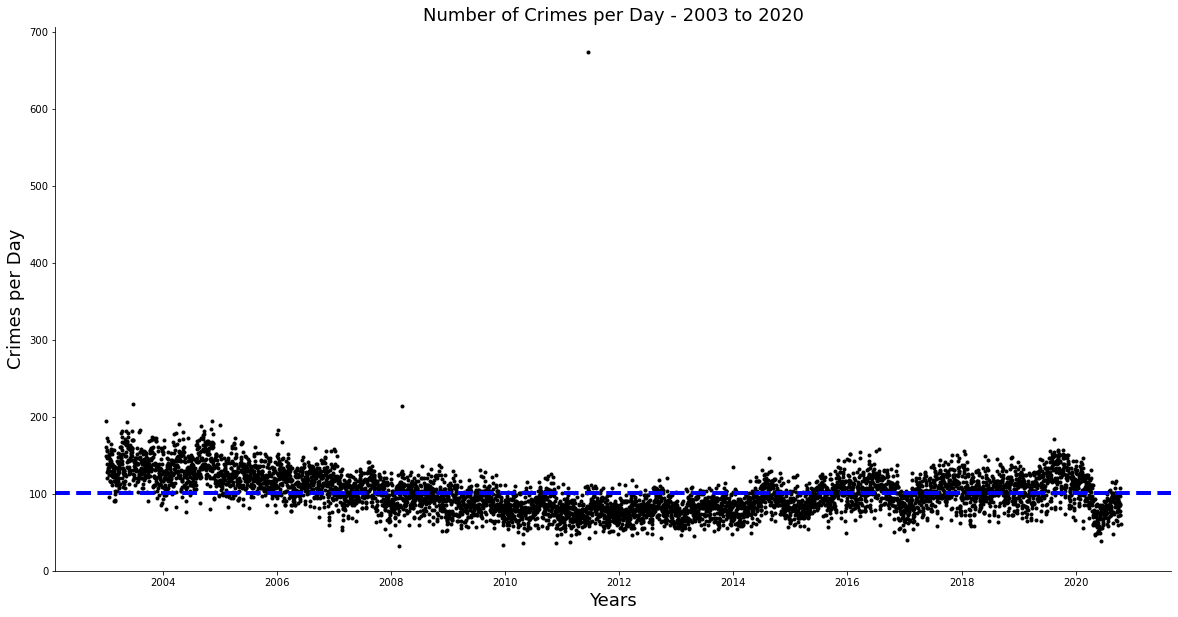

In [66]:
matplotlib.rcParams['figure.figsize'] = (20, 10)
df_prophet_all.plot(style='k.', legend = None)
plt.title("Number of Crimes per Day - 2003 to 2020", fontsize=18)
plt.ylabel("Crimes per Day", fontsize=18)
plt.xlabel("Years", fontsize=18)
plt.axhline(df_prophet_all["COUNT_OF_CRIMES"].mean(), color='B', linestyle='dashed', linewidth=4)
sns.despine()
plt.show()

> There is a clear outlier between 2010 and 2012, and to identify the exact date we will run a max on the dataframe:

In [67]:
df_prophet_all[df_prophet_all['COUNT_OF_CRIMES']==df_prophet_all['COUNT_OF_CRIMES'].max()]

,COUNT_OF_CRIMES
DATE_TIME,
2011-06-15,674


There is a clear outlier at June 15, 2011 due to the [2011 Vancouver Stanley Cup riot](https://en.wikipedia.org/wiki/2011_Vancouver_Stanley_Cup_riot) where the local hockey team, Vancouver Canucks lost the game seven of the Stanley Cup Finals.

For the model, we need to drop this outlier. 

In [68]:
# Replacing the outlier with NaN to avoid impacting the forecasting
df_prophet_all.replace(to_replace = 674, value = np.NaN, inplace=True)

In [69]:
# Checking if the NaN value was correctly pasted
df_prophet_all[df_prophet_all["COUNT_OF_CRIMES"].isna()]

,COUNT_OF_CRIMES
DATE_TIME,
2011-06-15,NaN


## Forecasting Daily Cases

### Prophet (Facebook)

#### Fitting Data

Prophet uses simulated historical forecasts (SHFs) by producing K forecasts at various cutoff points in the history, chosen such that the horizons lie within the history and the total error can be evaluated. The main advantage of using fewer simulated dates (rolling origin evaluation produces one forecast per date) is that it economizes on computation while providing less correlated accuracy measurements.

In [70]:
# Reseting the indexes
df_prophet_daily = df_prophet_all.reset_index().rename(columns={"DATE_TIME":"ds","COUNT_OF_CRIMES":"y"})

The dataframe for Prophet needs to have the column names as "ds" for the dates and "y" for the value to be forecasted:

In [79]:
df_prophet_daily.head()

,ds,y
0,2003-01-01,194.0
1,2003-01-02,149.0
2,2003-01-03,161.0
3,2003-01-04,147.0
4,2003-01-05,121.0


In [82]:
# Instantiate the model with 95% confidence intervals
daily = Prophet(interval_width = 0.95)

# Including the Canadian holidays to addapt to sazonality
daily.add_country_holidays(country_name='CA')

# Fit the model
daily.fit(df_prophet_daily)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
# List of Canadian Holidays that were considered in the forecast
daily.train_holiday_names

0                New Year's Day
1                   Good Friday
2                  Victoria Day
3                    Canada Day
4                    Labour Day
5                  Thanksgiving
6               Remembrance Day
7                 Christmas Day
8      Christmas Day (Observed)
9         Boxing Day (Observed)
10    New Year's Day (Observed)
11        Canada Day (Observed)
12                   Boxing Day
dtype: object

In [74]:
# Creating the future dataframe range (807 days in the future - until 2022-12-31)
future = daily.make_future_dataframe(periods=807,freq="D")
future.tail()

,ds
7300,2022-12-27
7301,2022-12-28
7302,2022-12-29
7303,2022-12-30
7304,2022-12-31


We will now run the model and and show the table with the forecasted values:

In [75]:
# Running the model and showing the last days prediction
forecast = daily.predict(future)

> __Yhat__: the forecasted value

> __yhat_lower__: lower band on the 95% confidence interval

> __yhat_upper__: upper band on the 95% confidence interval

In [76]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2003-01-01,167.422973,136.014854,198.564800
1,2003-01-02,134.352204,102.670934,165.799517
2,2003-01-03,145.161569,114.768759,177.181805
3,2003-01-04,145.741695,113.859995,179.198053
4,2003-01-05,137.793295,105.899009,168.734343
...,...,...,...,...
7300,2022-12-27,84.701829,53.622706,116.803885
7301,2022-12-28,90.259128,58.035412,120.737038
7302,2022-12-29,91.969399,60.898225,124.418361
7303,2022-12-30,102.837742,69.029846,136.112643


#### Plotting the Forecasted Data

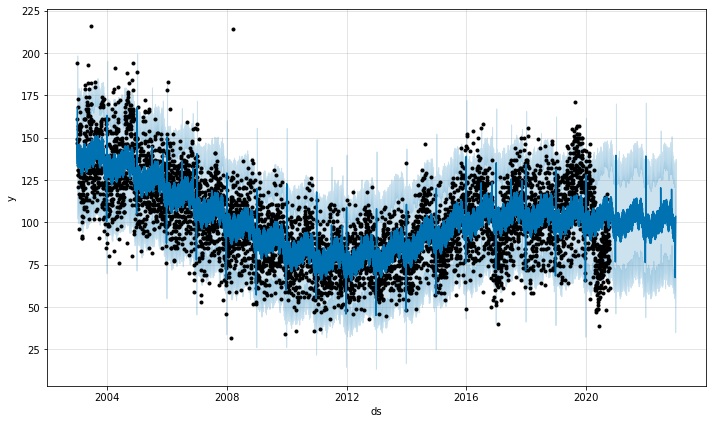

In [77]:
fig1 = daily.plot(forecast)

Prophet also detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. 

It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. 

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series.

The vertical lines in this figure indicate where the potential changepoints were placed:

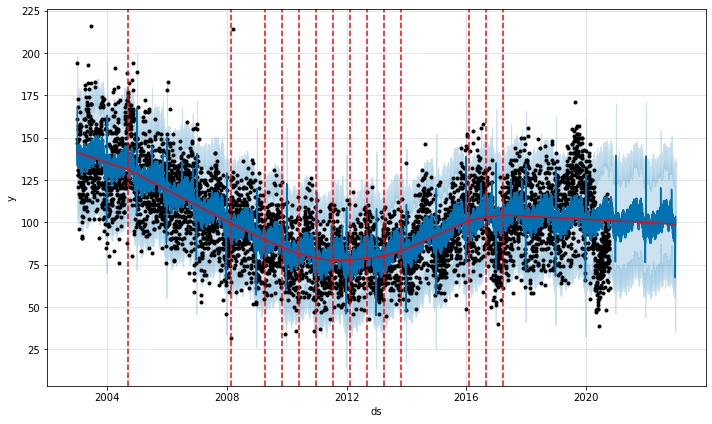

In [78]:
fig_changepoints = daily.plot(forecast)
a = add_changepoints_to_plot(fig_changepoints.gca(), daily, forecast)

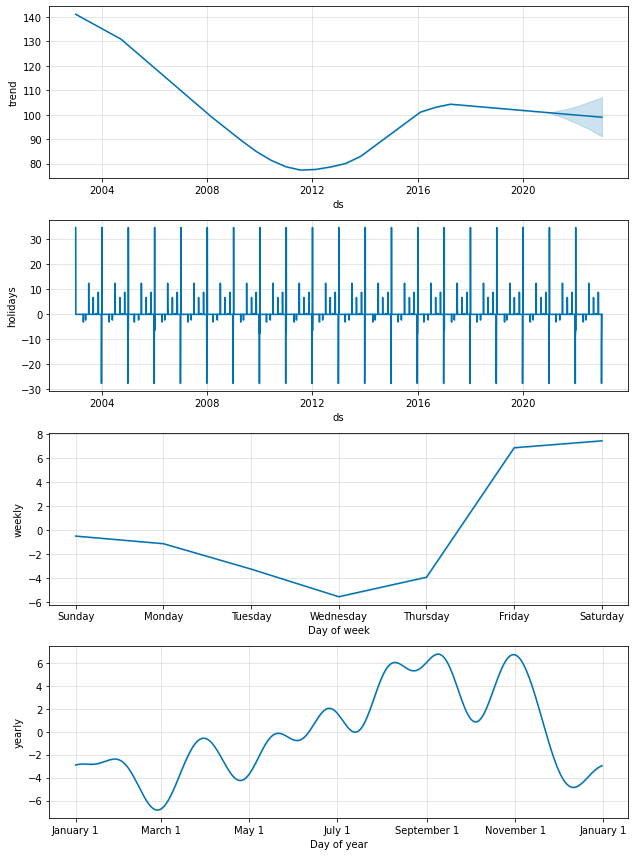

In [80]:
# Components of the forecast (trend and sazonality)
fig2 = daily.plot_components(forecast)

#### Diagnostics

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

We specify the forecast horizon, and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period).

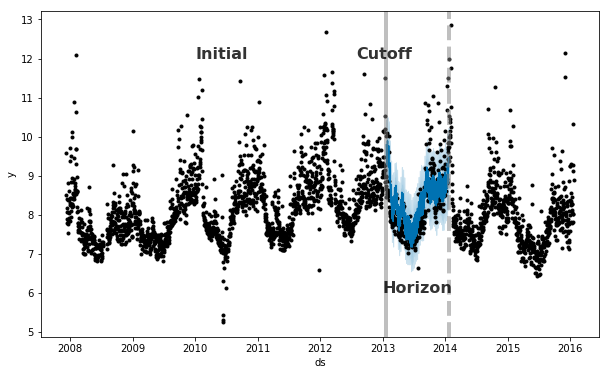

Here we will do a cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 182 days. On this 17 years time series, this corresponds to 30 total forecasts.

Prophet uses simulated historical forecasts (SHFs) by producing K forecasts at various _cutoff points_ in the history, chosen such that the horizons lie within the history and the total error can be evaluated. The main advantage of using fewer simulated dates (rolling origin evaluation produces one forecast per date) is that it economizes on computation while providing less correlated accuracy measurements.


Components of the cross_validation:
* __Initial__: range of the dataset to train the prediction
* __Period__: As a heuristic, for a forecast horizon H, we generally make a simulated forecast every H/2 periods.
* __Horizon__: The horizon is the number of days in the future we care about forecasting – this is typically 30, 90, 180, or 365 days.

In [85]:
# Initial= 3*365 (1095) / period = 182 / horizon = 365
df_cv = cross_validation(daily, initial='730 days', period='182 days', horizon = '365 days')

INFO:fbprophet:Making 30 forecasts with cutoffs between 2005-05-04 00:00:00 and 2019-10-16 00:00:00


In [87]:
# Forecast and Actuals
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
10943,2020-10-11,116.819287,86.359572,149.974546,85.0,2019-10-16
10944,2020-10-12,116.324785,85.863998,146.716780,97.0,2019-10-16
10945,2020-10-13,114.563684,85.503475,146.549104,77.0,2019-10-16
10946,2020-10-14,112.761527,82.588610,143.978279,73.0,2019-10-16
10947,2020-10-15,114.465459,83.784016,143.722290,61.0,2019-10-16


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.


We will now verify the performance of the 30 forecasts ran on our data:

In [88]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,233.346254,15.275675,12.009469,0.129528,0.105730,0.953870
1,38 days,236.218485,15.369401,12.134908,0.130612,0.107088,0.953382
2,39 days,238.676087,15.449145,12.193351,0.131741,0.107776,0.951554
3,40 days,241.021350,15.524862,12.228887,0.132266,0.107896,0.952163
4,41 days,241.765680,15.548816,12.234930,0.132366,0.107776,0.952041
...,...,...,...,...,...,...,...
324,361 days,287.238602,16.948115,13.463567,0.149761,0.120843,0.927910
325,362 days,287.547058,16.957213,13.470008,0.150041,0.121415,0.927849
326,363 days,285.407758,16.894015,13.389774,0.149184,0.119643,0.927361
327,364 days,284.197228,16.858150,13.364667,0.149814,0.120077,0.926935


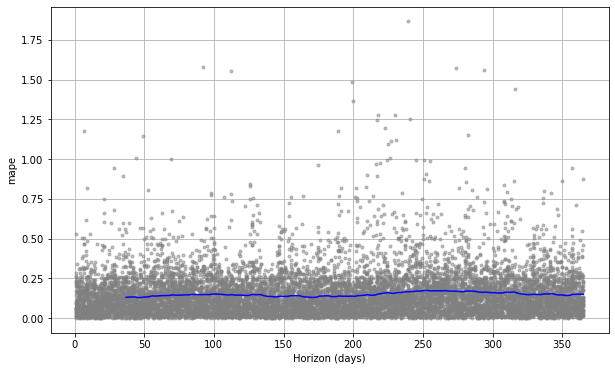

In [89]:
# mean absolute error (MAPE)
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [90]:
forecast_16_oct = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_16_oct[forecast_16_oct["ds"]=="2020-10-31"]

,ds,yhat,yhat_lower,yhat_upper
6513,2020-10-31,115.165674,83.471638,148.816328
